In [33]:
from scipy.stats import norm
def lin_reg(x, a, b, sigma=None):
    """Linear regression function with optional noise."""
    y = a * x + b
    if sigma is not None:
        y += norm(0, sigma).rvs(len(x))
    return y

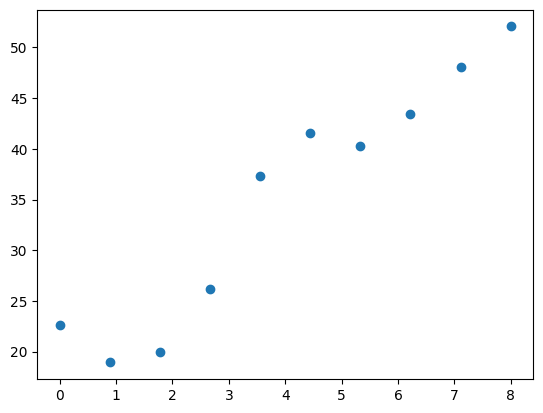

In [34]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
# generate data
n = 10
sigma = 5
data = pd.DataFrame(columns=['x', 'y'])
data['x'] = np.linspace(0, 8, n)
k = 3.4
c = 23
data['y'] = lin_reg(data['x'], k, c) + norm(0, sigma).rvs(n)
# plot data
plt.scatter(data['x'], data['y'])

In [35]:
# form combinations of parameters and define their priors
from itertools import product

# create parameter space for slope and intercept
resolution = 100
data_slope = np.linspace(-10, 10, num=resolution)
data_inter = np.linspace(-50, 50, num=resolution)

# create dataframe for parameters
df = pd.DataFrame(columns=['slope','intercept','prior'])
# parameter combinations
comb =list(product(data_slope, data_inter))
temp = pd.DataFrame(data=comb, columns=['slope','intercept'])

df['slope'] = temp['slope']
df['intercept'] = temp['intercept']
slope_prior = norm(1, 5).pdf(df['slope'])
intercept_prior = norm(20, 5).pdf(df['intercept'])
df['prior'] = slope_prior*intercept_prior
df.head()


,slope,intercept,prior
0,-10.0,-50.000000,1.556067e-46
1,-10.0,-48.989899,2.579132e-45
2,-10.0,-47.979798,4.103879e-44
3,-10.0,-46.969697,6.268893e-43
4,-10.0,-45.959596,9.193117e-42


In [36]:
# calculate likelihoods

for index, row in df.iterrows():
    y_pred = lin_reg(data['x'], row['slope'], row['intercept'])
    likelihoods = norm(y_pred, sigma).pdf(data['y'])
    df.at[index, 'likelihood'] = np.prod(likelihoods)

In [37]:
# calculate posterior
df['posterior'] = df['prior'] * df['likelihood']
# normalize
df['posterior'] = df['posterior'] / df['posterior'].sum()
df.head()

,slope,intercept,prior,likelihood,posterior
0,-10.0,-50.000000,1.556067e-46,0.0,0.0
1,-10.0,-48.989899,2.579132e-45,0.0,0.0
2,-10.0,-47.979798,4.103879e-44,0.0,0.0
3,-10.0,-46.969697,6.268893e-43,0.0,0.0
4,-10.0,-45.959596,9.193117e-42,0.0,0.0


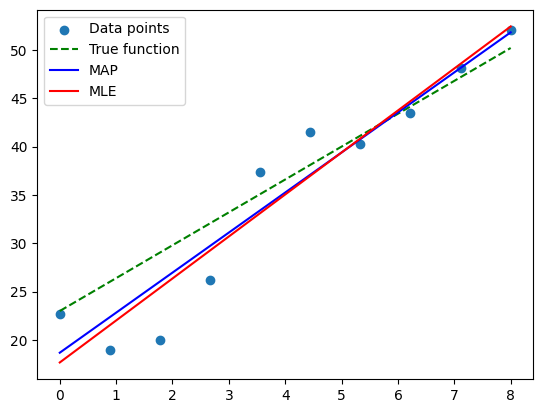

In [38]:
# plot data points
plt.scatter(data['x'], data['y'])
plt.plot(data['x'], 3.4*data['x']+23, 'g--')
# plot bayes
idx = df['posterior'].argmax()
k = df['slope'][idx]
c = df['intercept'][idx]
plt.plot(data['x'], data['x']*k + c, 'b')
# plot max likelihood
idx = df['likelihood'].argmax()
k = df['slope'][idx]
c = df['intercept'][idx]

plt.plot(data['x'], data['x']*k + c, 'r')
plt.legend(['Data points', 'True function', 'MAP', 'MLE'])


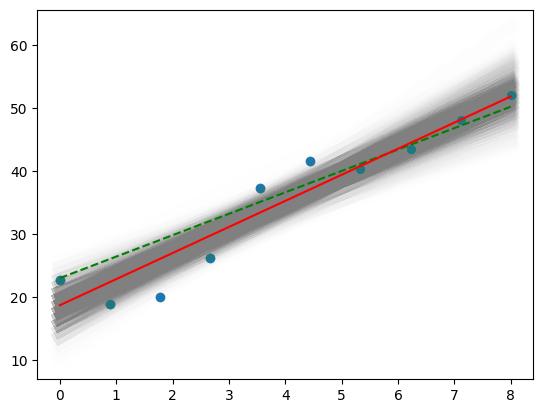

In [46]:
# sample from posterior
n_samp = 500
samp = df.sample(n_samp, weights=df['posterior'], replace=True)
for index, row in samp.iterrows():
    plt.plot(data['x'], lin_reg(data['x'], row['slope'], row['intercept']), color='gray', alpha=0.002, lw=10)


# plot data points
plt.scatter(data['x'], data['y'])
plt.plot(data['x'], lin_reg(data['x'], 3.4, 23), 'g--')
# plot bayes
idx = df['posterior'].argmax()
k = df['slope'][idx]
c = df['intercept'][idx]
plt.plot(data['x'], lin_reg(data['x'], k, c), 'r')


